<a href="https://colab.research.google.com/github/Gulzar-khan/Appliances-Energy-Prediction/blob/main/Capstone_Project_Appliances_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-driven prediction of energy use of appliances

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

date time year-month-day hour:minute:second

Appliances, energy use in Wh (Dependent variable)

lights, energy use of light fixtures in the house in Wh (Drop this column)

T1, Temperature in kitchen area, in Celsius

RH1, Humidity in kitchen area, in % 

T2, Temperature in living room area, in Celsius 

RH2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH3, Humidity in laundry room area, in % 

T4, Temperature in office room, in Celsius 

RH4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH5, Humidity in bathroom, in % 

T6, Temperature outside the building (north side), in Celsius

RH6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH7, Humidity in ironing room, in % 

T8, Temperature in teenager room 2, in Celsius 

RH8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH9, Humidity in parents room, in % 

To, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg 

RHout, Humidity outside (from
Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

In [1]:
pip install scikit-optimize  #for skopt and skopt.space

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.2 MB/s 


In [2]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [3]:
#Importing all the libarary
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import shap 
import graphviz

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Connect with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_energy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Almabetter/ML/project/data_application_energy.csv')

In [6]:
#According to questions drop 'lights' column
df_energy=df_energy.drop('lights',axis=1)

Lights dropping reason: As given in the problem statement

In [7]:
#Make an copy of our original data
df=df_energy.copy()

In [8]:
df.head()

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [9]:
df.shape

(19735, 28)

# EDA

In [10]:
df.columns

Index(['date', 'Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [11]:
df.describe()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-null  float64
 19  RH_9

In [13]:
# OR
df.isnull().values.any()

False

In [14]:
#OR
print(df.isnull().sum())

date           0
Appliances     0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


Therefore there is no null values

In [15]:
#Checking dupliates
df[df.duplicated()].sum()

date           0.0
Appliances     0.0
T1             0.0
RH_1           0.0
T2             0.0
RH_2           0.0
T3             0.0
RH_3           0.0
T4             0.0
RH_4           0.0
T5             0.0
RH_5           0.0
T6             0.0
RH_6           0.0
T7             0.0
RH_7           0.0
T8             0.0
RH_8           0.0
T9             0.0
RH_9           0.0
T_out          0.0
Press_mm_hg    0.0
RH_out         0.0
Windspeed      0.0
Visibility     0.0
Tdewpoint      0.0
rv1            0.0
rv2            0.0
dtype: float64

In [16]:
#OR
len(df[df.duplicated()])

0

There is no duplicates

In [17]:
#dropping Duplicates
# df.drop_duplicates(keep='first', inplace=True)

Checking Outliers

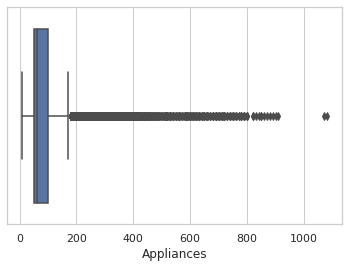

In [18]:
# Find outliers

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

From above boxplots we can say that there are lot of outliers in our target features

In [19]:
# Creating fuction for Removing the outliers
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

In [20]:
#Another method for Outliers removal

# df = df.dropna()
# df = df.drop(df[(df.Appliances>790)|(df.Appliances<0)].index)

In [21]:
for i in df.columns:
      if i == df.columns[1]:
        removeOutliers(df, i) 
# Assigning filtered data back to our original variable
df = filtered_data
print("Shape of data after outlier removal is: ", df.shape)

IQR value for column Appliances is: 50.0
Shape of data after outlier removal is:  (17597, 28)


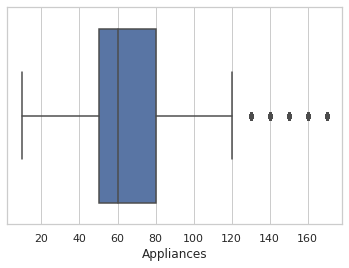

In [22]:
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

As we can see all Outliers are gone from our Dataset according to IQR method

Normality Checking of Taget Feature

In [23]:
target_var_original = df[['Appliances']]
# Creating normality check function
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=plt)
    plt.show()

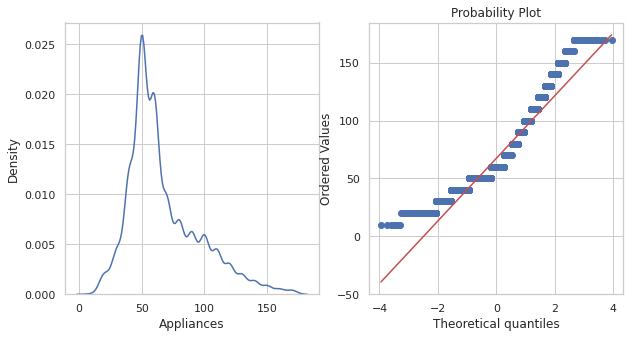

In [24]:
#Normality checking via created function
normality(target_var_original,'Appliances')

In [25]:
# Checking Skewness
target_var_original['Appliances'].skew()

1.0793897793506109

So our graph is movig towards to y axis as it is positively skewed and we couldn't get any better visualziation with these type of graph.
<br>So,It better to take Log or Square Root or Exponential of the dependent variable to draw the graph.

**Let's take a log of Appliances and draw the plot.....

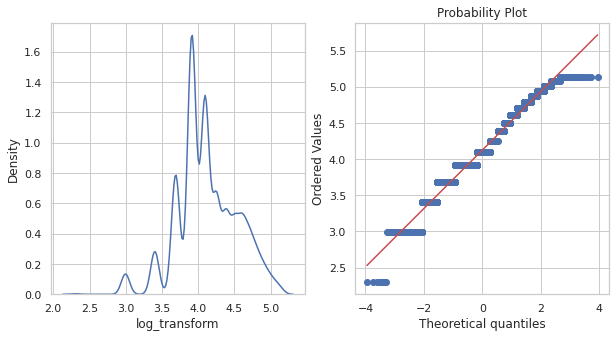

In [26]:
# Logarithmic Transformation – This will convert the Price value to its log value i.e log(Appliances)
target_var_original['log_transform']=np.log(target_var_original['Appliances'])
normality(target_var_original,'log_transform')

In [27]:
# Checking Skewness
target_var_original['log_transform'].skew()

-0.03727741267472712

**Let's take a Square Root of Appliances and draw the plot.....

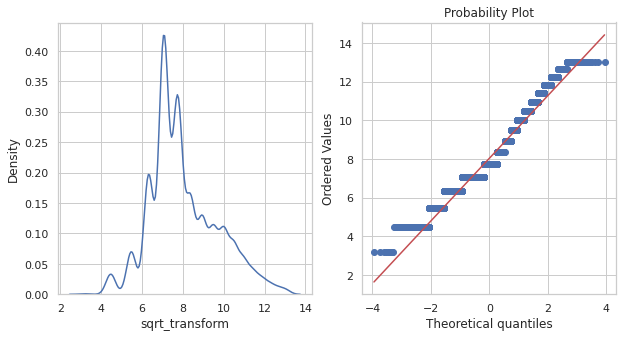

In [28]:
# Square Root Transformation – This transformation will take the square root of the Price column i.e sqrt(Appliances).
target_var_original['sqrt_transform']=np.sqrt(df.Appliances)
normality(target_var_original,'sqrt_transform')

In [29]:
# Checking Skewness
target_var_original['sqrt_transform'].skew()

0.5743520376079689

Observation:
We observe that none of the transformations are making our target variable perfectly normal, but still Square Root trasnformation is 
giving better results than others.

The Square root Transformation has kind of converted the feature to almost normal distributed. Most of the data points are also falling on the line in the Q-Q plot. This one is better than the log transformation for the Appliances feature. So we will be applying Square Root transformation on the target variable.

In [30]:
#Applying sqare root transformation to our target column
# df['Appliances']=np.sqrt(df.Appliances)

Featching information from Date column

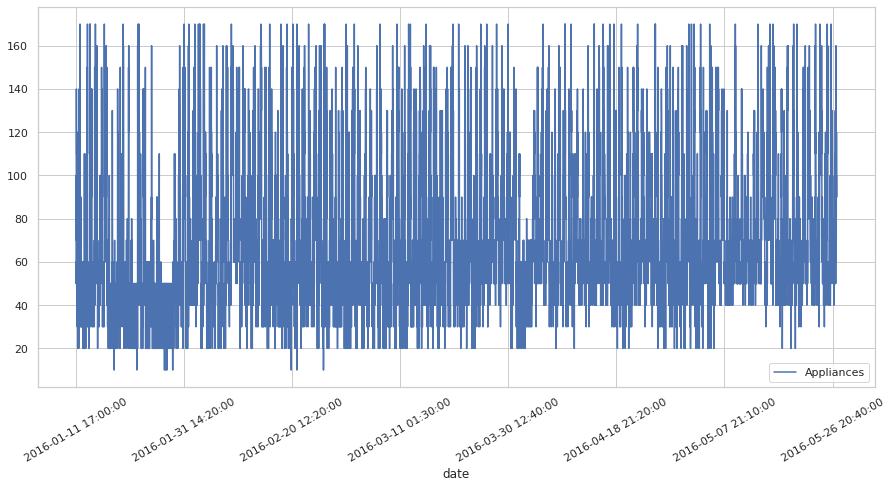

In [31]:
# checking Data regarding date and time
df.plot(x='date', y='Appliances', figsize=(15,7), rot=30);


Observation-
The data contains date and time as well.This may be a case of time-series forecasting problem. **As of now, I am not proceeding with time-series approach.** I will be solving the problem using general ML techniques. But if given more time, i would give a chance to time-series also(AFTER TIME SERIES LECTURE COMPLETION) and would check how our data behaves on time-series models.

Even if we are not proceeding with time-series appraoch, we can extract useful information from the datetime feature.

In [32]:
df['date']

0        2016-01-11 17:00:00
1        2016-01-11 17:10:00
2        2016-01-11 17:20:00
3        2016-01-11 17:30:00
4        2016-01-11 17:40:00
                ...         
19727    2016-05-27 16:50:00
19728    2016-05-27 17:00:00
19729    2016-05-27 17:10:00
19730    2016-05-27 17:20:00
19731    2016-05-27 17:30:00
Name: date, Length: 17597, dtype: object

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a mesured load is lower or higher in comparison to the average energy load a given time interval.

I will append several columns as new features to the original data, based on the above-mentioned assumptions and then i will find out which of them explain better appliances consumption.

In [33]:
df['date'] = pd.to_datetime(df['date'])

In [34]:
df['month'] = df.date.dt.month       
df['weekday'] = df.date.dt.weekday   
df['hour'] = df.date.dt.hour         
df['week'] = df.date.dt.week         

In [35]:
# Dropping 'date' column
df.drop(columns=['date'], inplace=True)

Date dropping reason: As we are not trying to analyze the problem as Time Series rather regress on "Appliance" column.



In [36]:
# Creating Functions to get daily data respect to Appliances energy consumption in Wh

def daily(x,df=df):
    return df.groupby('weekday')[x].mean()

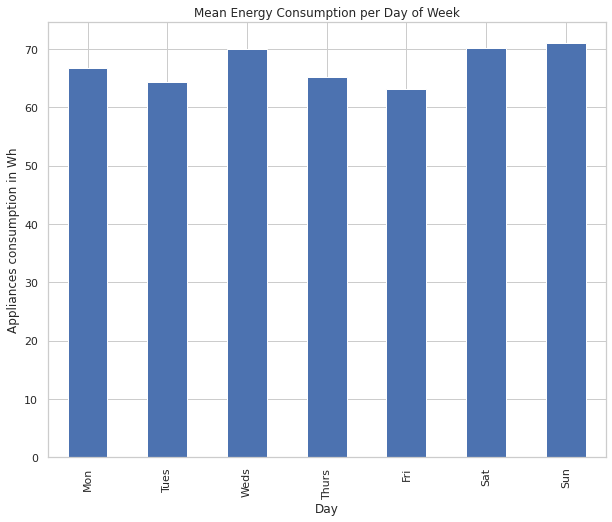

In [37]:
# Plot of Mean Energy Consumption per Day of Week

daily('Appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

Observation-

We can see that everyday, the usage is maximum on wednesday and weekend(specially sunday). It is maximum because of weekend holiday.

In [38]:
# Creating Functions to get hourly data respect to Appliances energy consumption in Wh

def hourly(x,df=df):
    return df.groupby('hour')[x].mean()

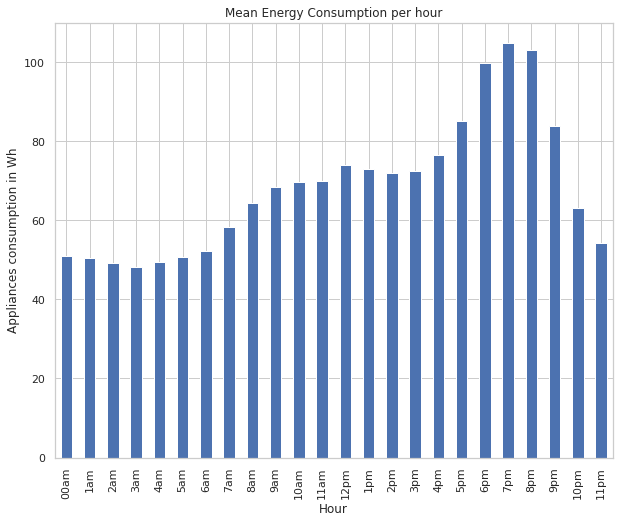

In [39]:
# Plot of Mean Energy Consumption per Day of Week

hourly('Appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 24, 1)) 
labels = "00am 1am 2am 3am 4am 5am 6am 7am 8am 9am 10am 11am 12pm 1pm 2pm 3pm 4pm 5pm 6pm 7pm 8pm 9pm 10pm 11pm".split()
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per hour')
plt.xticks(ticks, labels);

Above figure is a representation of average energy consumption of appliances at different time of the day over a period of 4.5 months. We observe two peak hours. One at 12 pm in the morning and other at 7 PM in the evening. While the peak at 12 pm is shallow and low, peak at 7 PM is comparatively higher and sharper.
We observe that over the sleeping hours (10 PM - 6 AM) the energy consumption of appliances is around 50 Wh. After about 6 am, energy consumption starts to rise gradually up until 12 pm (probably due to morning chores). And then gradually decreases to around 75 Wh at about 2 PM. After which the energy consumption drastically shoots up up until 7 PM in the evening (probably due to requirement lights in rooms). However energy consumption of appliances reverts back to 50 Wh, as night approaches and people in the house go to bed at around 11 PM.

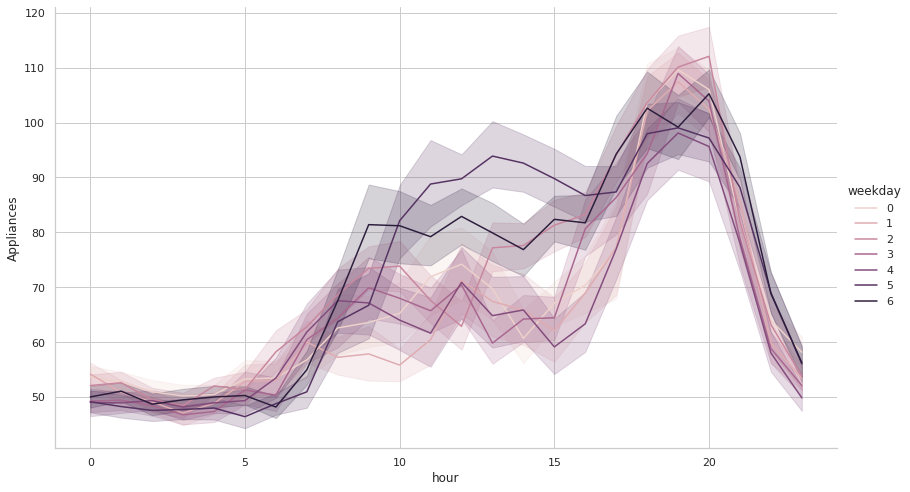

In [40]:
sns.relplot(y='Appliances', x='hour', data=df, kind='line', hue='weekday', height=7, aspect=1.7)
plt.show()

We observe that the energy consumption of appliances during the office hours (8 AM - 4 PM) is higher in weekends compared to the weekdays. Also, average overall consumption is higher in weekends is pretty high.

In [41]:
#Grouping column according to their type
temp_cols = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]
humidity_cols = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]
weather_cols = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"] 
random_cols = ["rv1", "rv2"]
target = ["Appliances"]

Checking distribution of features:-

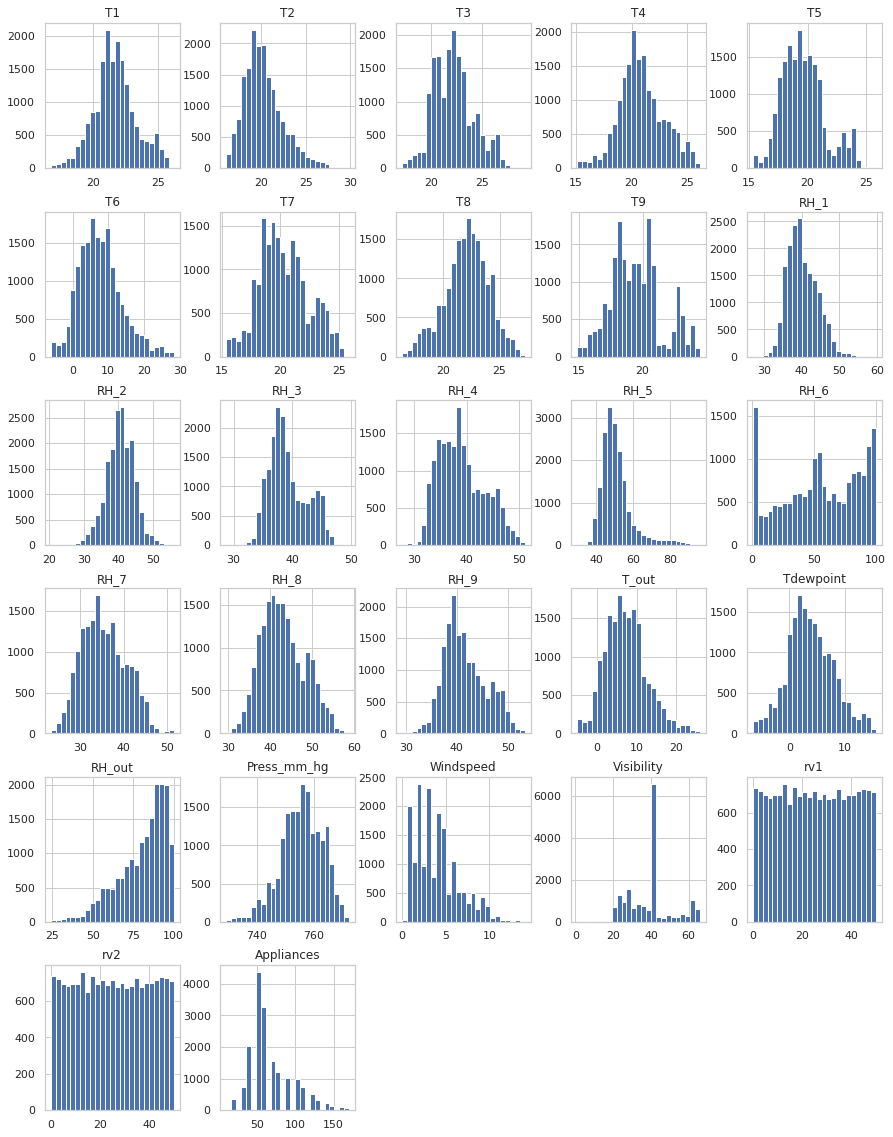

In [42]:
df[temp_cols+ humidity_cols+ weather_cols + random_cols+ target].hist(bins=25, figsize=(15,20));

In [43]:
df.skew()

Appliances     1.079390
T1             0.106392
RH_1           0.471071
T2             0.860361
RH_2          -0.302516
T3             0.413493
RH_3           0.481905
T4             0.151715
RH_4           0.455104
T5             0.550737
RH_5           1.838538
T6             0.587853
RH_6          -0.247152
T7             0.247172
RH_7           0.255466
T8            -0.273553
RH_8           0.330635
T9             0.369798
RH_9           0.380360
T_out          0.516237
Press_mm_hg   -0.414774
RH_out        -0.992142
Windspeed      0.910927
Visibility     0.417426
Tdewpoint      0.229723
rv1            0.001072
rv2            0.001072
month         -0.087260
weekday        0.039560
hour           0.083379
week          -0.013918
dtype: float64

Positively skewed(>1):- Appliances, RH_5.

Moderately Positively skewed(0.5 to 1):- T2, T5, T6, T_out, RH_out, Windspeed.

Normal Distributed(-0.5 to +0.5):- T1, T3, T4, T7, T8, T9, RH_1, RH_2, RH_3, RH_4, RH_6, RH_7, RH_8, RH_9, Press_mm_hg, Visibility, Tdewpoint, rv1, rv2,

Negative skewed(-0.5 to -1):- No features.

Moderately Negtively skewed(>-1):- RH_out.



In [44]:
#Dropping month,week,weekday and hour as these col have no use now
df.drop(columns=['month','weekday','hour','week'], inplace=True)

In [45]:
df.head(3)

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


# Features Selection 

Via correlation

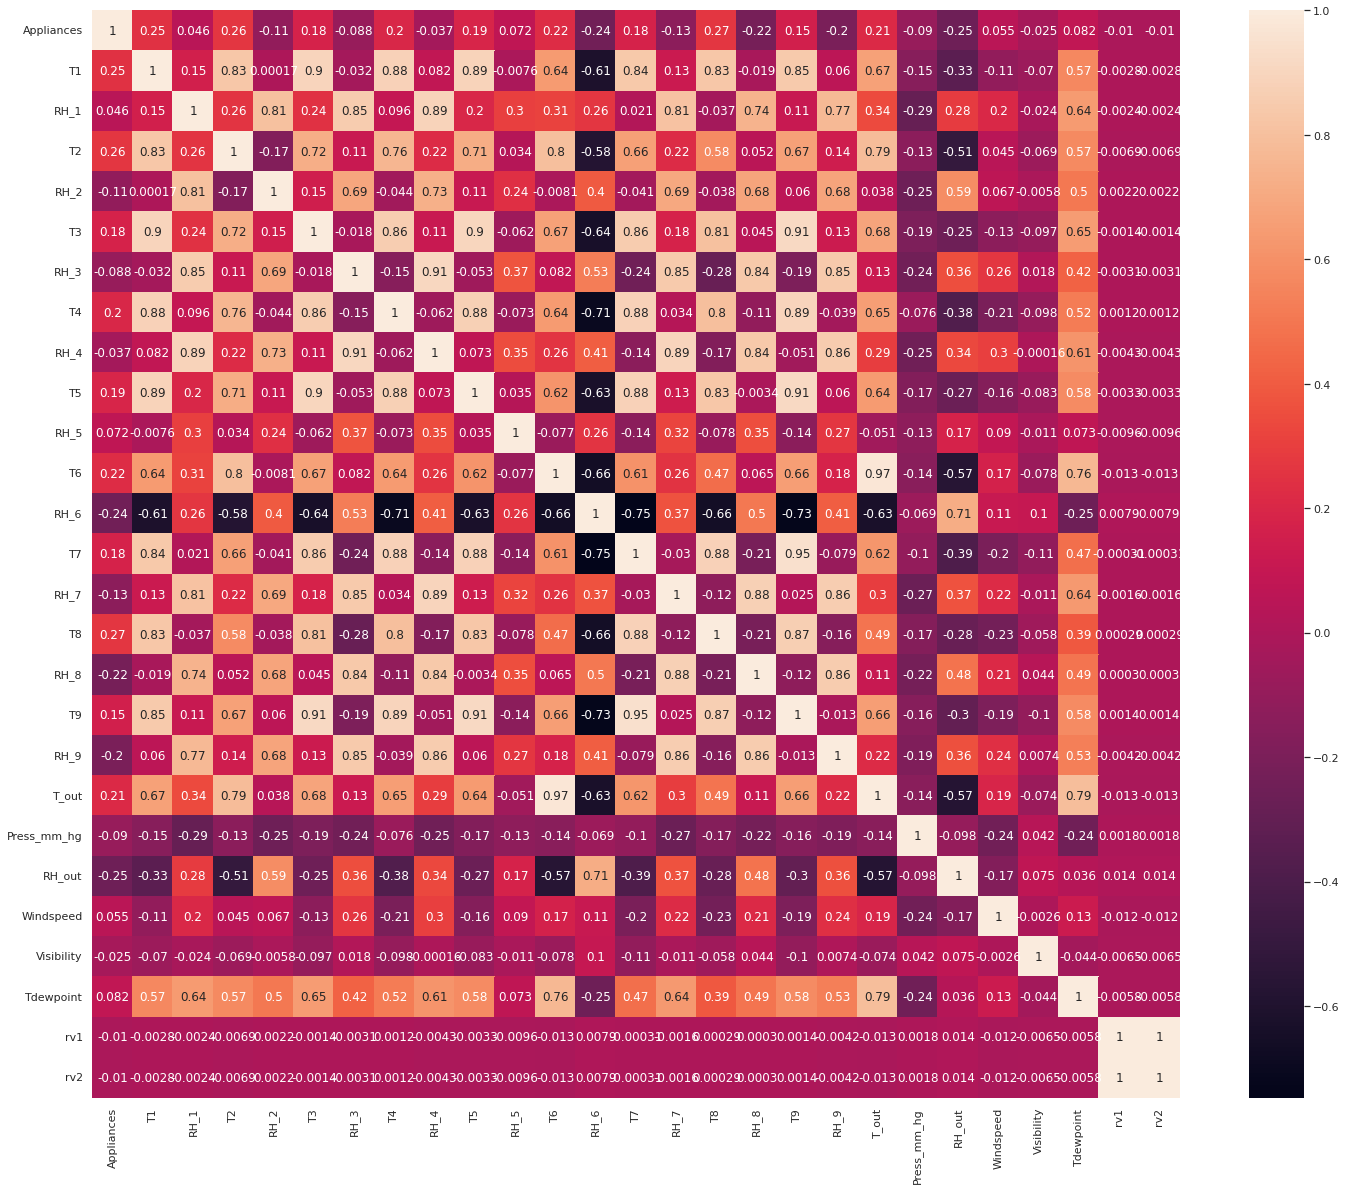

In [46]:
# Heatmap is good with Square Root transformation on target variable in this scenario

fig = plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, square=True);

Observation:¶
From the above heatmaps, we observe that after square root trasnformation, our target variable is showing better relationship with other variables. That's a good thing for us.

# Observations based on correlation plot:-
1. Temperature - All the temperature variables from T1-T9 and T_out have positive correlation with the target Appliances . 
 

2. Five columns have a high degree of correlation with T9 - T3,T4,T5,T7,T8 also T6 & T_Out has high correlation(both temperatures from outside) . Hence T6 and T9 can be removed from training set as information provided by them can be provided by other fields.

3. Weather attributes - Visibility, Tdewpoint, Press_mm_hg have low correlation values

4. Humidity - RH_3 & RH_4 has high correlation(both temperatures from outside) . Hence RH_3 or RH_4 can be removed from training set as information provided by them can be provided by other fields.
There are no significantly high correlation cases (> 0.9) for humidity sensors.

5. Random variables have no role to play

In [47]:
# #Remove unneccessary column
df.drop(["rv1","rv2","T6","T9",'RH_3'],axis=1 , inplace=True)


In [48]:
corr_tran_df =df.corr()
corr_tran_df

,Appliances,T1,RH_1,T2,RH_2,T3,T4,RH_4,T5,RH_5,...,RH_7,T8,RH_8,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
Appliances,1.000000,0.248221,0.045596,0.264739,-0.109746,0.180061,0.195689,-0.036932,0.191782,0.072040,...,-0.128740,0.268293,-0.218639,-0.201968,0.213651,-0.089829,-0.252696,0.055363,-0.024974,0.081550
T1,0.248221,1.000000,0.153799,0.831967,0.000171,0.897053,0.881085,0.081965,0.887043,-0.007641,...,0.125281,0.832588,-0.018747,0.060026,0.670593,-0.152247,-0.332730,-0.107067,-0.070405,0.565168
RH_1,0.045596,0.153799,1.000000,0.256932,0.806895,0.243415,0.096399,0.890015,0.196578,0.303219,...,0.811149,-0.037339,0.742213,0.770466,0.339477,-0.288807,0.284023,0.203744,-0.023531,0.642200
T2,0.264739,0.831967,0.256932,1.000000,-0.169432,0.724341,0.758124,0.218405,0.713467,0.033758,...,0.218668,0.577031,0.052209,0.143615,0.787394,-0.133023,-0.508107,0.044776,-0.069210,0.573864
RH_2,-0.109746,0.000171,0.806895,-0.169432,1.000000,0.151695,-0.044259,0.727150,0.110604,0.241353,...,0.693858,-0.038205,0.681128,0.680480,0.038352,-0.251208,0.588761,0.067110,-0.005777,0.504801
T3,0.180061,0.897053,0.243415,0.724341,0.151695,1.000000,0.862704,0.113369,0.899945,-0.062262,...,0.175432,0.807573,0.044596,0.130937,0.684701,-0.192824,-0.251120,-0.128159,-0.097455,0.648264
T4,0.195689,0.881085,0.096399,0.758124,-0.044259,0.862704,1.000000,-0.062208,0.877143,-0.073263,...,0.034278,0.801918,-0.110301,-0.039221,0.654619,-0.076398,-0.378222,-0.205010,-0.097992,0.516391
RH_4,-0.036932,0.081965,0.890015,0.218405,0.727150,0.113369,-0.062208,1.000000,0.073212,0.349692,...,0.891678,-0.172805,0.842411,0.855029,0.292575,-0.246577,0.335375,0.301535,-0.000155,0.611988
T5,0.191782,0.887043,0.196578,0.713467,0.110604,0.899945,0.877143,0.073212,1.000000,0.034662,...,0.133764,0.831978,-0.003364,0.059772,0.639284,-0.170841,-0.266433,-0.162083,-0.082764,0.578821
RH_5,0.072040,-0.007641,0.303219,0.033758,0.241353,-0.062262,-0.073263,0.349692,0.034662,1.000000,...,0.317616,-0.078357,0.354224,0.266899,-0.050711,-0.125086,0.174680,0.089533,-0.010511,0.072796


In [49]:
corr_appliances = corr_tran_df[['Appliances']]
corr_appliances

,Appliances
Appliances,1.000000
T1,0.248221
RH_1,0.045596
T2,0.264739
RH_2,-0.109746
T3,0.180061
T4,0.195689
RH_4,-0.036932
T5,0.191782
RH_5,0.072040


In [50]:
#sorting
corr_appliances.sort_values('Appliances', inplace=True)


In [51]:
corr_appliances

,Appliances
RH_out,-0.252696
RH_6,-0.240142
RH_8,-0.218639
RH_9,-0.201968
RH_7,-0.128740
RH_2,-0.109746
Press_mm_hg,-0.089829
RH_4,-0.036932
Visibility,-0.024974
RH_1,0.045596


In [52]:
#overview of other columns regarding to our terms
~corr_appliances['Appliances'].between(-0.21, 0.00)

RH_out          True
RH_6            True
RH_8            True
RH_9           False
RH_7           False
RH_2           False
Press_mm_hg    False
RH_4           False
Visibility     False
RH_1            True
Windspeed       True
RH_5            True
Tdewpoint       True
T7              True
T3              True
T5              True
T4              True
T_out           True
T1              True
T2              True
T8              True
Appliances      True
Name: Appliances, dtype: bool

In [53]:
#remove those features which are negatively correlated  upto -0.21 to our target column('Appliances')
imp_features= corr_appliances.loc[~corr_appliances['Appliances'].between(-0.21, 0.00)]

In [54]:
imp_features

,Appliances
RH_out,-0.252696
RH_6,-0.240142
RH_8,-0.218639
RH_1,0.045596
Windspeed,0.055363
RH_5,0.072040
Tdewpoint,0.081550
T7,0.175519
T3,0.180061
T5,0.191782


In [55]:
#taking the list of imp features for our target feature
imp_features_list = imp_features.index.tolist()
imp_features_list

['RH_out',
 'RH_6',
 'RH_8',
 'RH_1',
 'Windspeed',
 'RH_5',
 'Tdewpoint',
 'T7',
 'T3',
 'T5',
 'T4',
 'T_out',
 'T1',
 'T2',
 'T8',
 'Appliances']

In [56]:
#making df of this imp features list
imp_df = df[imp_features_list]



In [57]:
#checking out col of imp df
imp_df.columns

Index(['RH_out', 'RH_6', 'RH_8', 'RH_1', 'Windspeed', 'RH_5', 'Tdewpoint',
       'T7', 'T3', 'T5', 'T4', 'T_out', 'T1', 'T2', 'T8', 'Appliances'],
      dtype='object')

In [58]:
#check out shape
imp_df.shape

(17597, 16)

Features Selection via VIF

NOTE:- It didn't Give us a good result so I decluded it.

In [59]:
#FOR VIF METHOD 

#Multicollinearity
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

In [60]:
#FOR VIF METHOD ONLY

# print('max:',df['Appliances'].max())
# print('min:',df['Appliances'].min())

# sns.distplot(np.array(df['Appliances']))

In [61]:
# FOR VIF METHOD ONLY

# calc_vif(df[[i for i in df.describe().columns if i not in ['Appliances']]])

In [62]:
#DROPPING COLIMN ACCORDING TO VIF ONE BY ONE

# df=df.drop(['rv1','rv2'],axis=1)
# df=df.drop(['T1'],axis=1)
# df=df.drop(['T9'],axis=1)
# df=df.drop(['Press_mm_hg'],axis=1)
# df=df.drop(['RH_2'],axis=1)
# df=df.drop(['RH_3'],axis=1)   #R2_SCORE
# df=df.drop(['T7'],axis=1)     #0.6989
# df=df.drop(['RH_4'],axis=1)   #0.6957
# till here max results

# df=df.drop(['T3'],axis=1)     #0.6947
# df=df.drop(['T5'],axis=1)     #0.6941
# df=df.drop(['T4'],axis=1)     #0.6911
# df=df.drop(['RH_9'],axis=1)
# df=df.drop(['RH_8'],axis=1)   #0.6925
# df=df.drop(['T8'],axis=1)     #0.6784
# df=df.drop(['RH_1'],axis=1)   #0.6650
# df=df.drop(['T2'],axis=1)     #0.6562
# df=df.drop(['RH_7'],axis=1)   #0.6441
# df=df.drop(['T_out'],axis=1)  #0.6383
# df=df.drop(['RH_out'],axis=1) #0.6264
# df=df.drop(['RH_5'],axis=1)   #0.5836

# df=df.drop(['T6'],axis=1)
# df=df.drop(['Visibility'],axis=1)
# df.columns()

In [63]:
#FOR VIF METHOD

# app=df[['Appliances']]
# dff=df.drop(['Appliances'],axis=1)

In [64]:
#FOR VIF METHOD ONLY

# X=dff
# y=app

Processing the data before feeding it to ML models.¶


In [65]:
#Defining X and y for split
X = imp_df.drop(columns=['Appliances'])
y = imp_df[['Appliances']]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [67]:
# Scale the data (used MinMax also but did'nt give promising results)
scaler = StandardScaler() 
X_train_sc=scaler.fit_transform(X_train)
X_test_sc=scaler.transform(X_test)

APPLYING PCA BUT IT IS NOT GIVING GOOD RESULTS

In [68]:
# Applying PCA
# pca = PCA(n_components = 0.99)
# X_train_sc = pca.fit_transform(X_train_sc)
# X_test_sc = pca.transform(X_test)

In [69]:
# pca.components_

In [70]:
# pca.explained_variance_

# Making Models

In [71]:
models = [
           ['LinearRegression: ', LinearRegression()],
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['DecisionTreeRegresson: ', DecisionTreeRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['GradientBoostingRegression: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()],
           ['AdaBoostRegressor: ',AdaBoostRegressor()],
           ['LgbmRegressor: ',lgbm.LGBMRegressor()]
         ]

In [72]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train_sc,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train_sc))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test_sc))
    # curr_model_data["Test_MSE_Score"] = mean_squared_error(y_test_sc,curr_model.predict(X_test_sc))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test_sc)))
    model_data.append(curr_model_data)


[05:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
model_data

[{'Name': 'LinearRegression: ',
  'Test_R2_Score': 0.3037572349356845,
  'Test_RMSE_Score': 23.952440521919296,
  'Train_R2_Score': 0.2743210752385271,
  'Train_Time': 0.024745464324951172},
 {'Name': 'Lasso: ',
  'Test_R2_Score': 0.24593440655377086,
  'Test_RMSE_Score': 24.92722796255813,
  'Train_R2_Score': 0.22674728092143048,
  'Train_Time': 0.06666731834411621},
 {'Name': 'Ridge: ',
  'Test_R2_Score': 0.3037410802807946,
  'Test_RMSE_Score': 23.952718399970827,
  'Train_R2_Score': 0.2743209546724492,
  'Train_Time': 0.012333869934082031},
 {'Name': 'DecisionTreeRegresson: ',
  'Test_R2_Score': 0.5226090484107626,
  'Test_RMSE_Score': 19.833826706366622,
  'Train_R2_Score': 1.0,
  'Train_Time': 0.3195152282714844},
 {'Name': 'RandomForest ',
  'Test_R2_Score': 0.714271869053082,
  'Test_RMSE_Score': 15.344259087092416,
  'Train_R2_Score': 0.9569336689663508,
  'Train_Time': 16.304368019104004},
 {'Name': 'GradientBoostingRegression: ',
  'Test_R2_Score': 0.4211061603913274,
  'Tes

In [74]:
# making Dataframe of resuls
result= pd.DataFrame(model_data)

In [75]:
#showing results
result

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,LinearRegression:,0.024745,0.274321,0.303757,23.952441
1,Lasso:,0.066667,0.226747,0.245934,24.927228
2,Ridge:,0.012334,0.274321,0.303741,23.952718
3,DecisionTreeRegresson:,0.319515,1.000000,0.522609,19.833827
4,RandomForest,16.304368,0.956934,0.714272,15.344259
5,GradientBoostingRegression:,4.665111,0.435529,0.421106,21.840817
6,XGBRegressor:,1.882659,0.435198,0.422957,21.805876
7,AdaBoostRegressor:,2.480146,0.070496,0.098433,27.256395
8,LgbmRegressor:,0.498985,0.689902,0.611088,17.901727


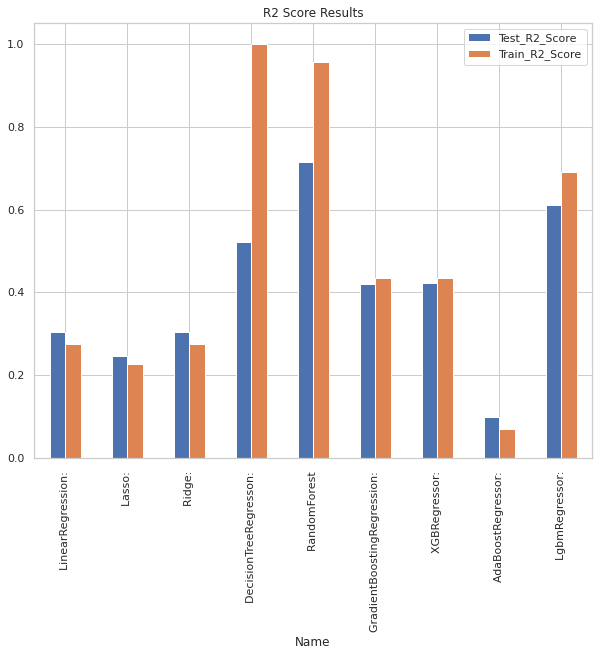

In [84]:
result.plot(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' ,], kind="bar" , title = 'R2 Score Results' , figsize= (10,8)) 

Observation:
The model which has minimum rmse and maximum r2 is performing the best. Hence, Random Forest is performing the best but it is overfitting model.

Test r2: 0.958

Test r2: 0.7190

Test RMSE: 0.892

Sowe are going for Hypertuning with Lgbm as well as RandomForest


	

# Hyper parameter tuning

We will only go for Random Forest Regressor and Lgbm Regressor as these are in giving good results in comparison to others.

RF for Bayes search :-

In [658]:
reg = RandomForestRegressor(random_state=40)
# Instantiate the bayes search model
bayes_search = BayesSearchCV(estimator=reg,
                       search_spaces = {
                          'max_depth': Integer(13,15),
                          'min_samples_leaf': Integer(1,2),
                          'min_samples_split': Integer(2,3),
                          'n_estimators': Integer(135,140),
                          'max_features': ["auto", "sqrt", "log2"]
                        },
                       cv = 5, verbose=2, scoring='r2')

bayes_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=136; total time=  12.5s
[CV] END max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=136; total time=  12.4s
[CV] END max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=136; total time=  12.4s
[CV] END max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=136; total time=  12.4s
[CV] END max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=136; total time=  12.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=138; total time=   3.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=138; total time=   3.2s
[CV] END max_depth=15, max_features=log2, 

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=40),
              scoring='r2',
              search_spaces={'max_depth': Integer(low=13, high=15, prior='uniform', transform='normalize'),
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': Integer(low=1, high=2, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=3, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=135, high=140, prior='uniform', transform='normalize')},
              verbose=2)

In [659]:
bayes_search.best_params_

OrderedDict([('max_depth', 15),
             ('max_features', 'auto'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 3),
             ('n_estimators', 140)])

In [664]:
# R2 score on training set with tuned parameters

bayes_search.best_estimator_.score(X_train_sc,y_train)

0.8673879071620694

In [665]:
# R2 score on test set with tuned parameters
bayes_search.best_estimator_.score(X_test_sc,y_test)


0.6926892917301131

In [666]:
# RMSE score on test set with tuned parameters

np.sqrt(mean_squared_error(y_test, bayes_search.best_estimator_.predict(X_test_sc)))

15.913227424059706

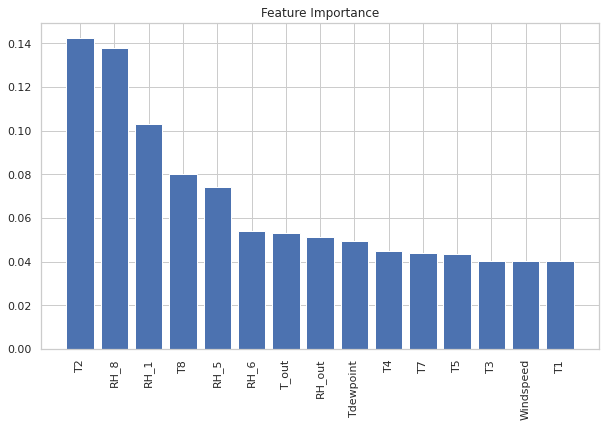

In [667]:
importances = bayes_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(10,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

Observation:
With hyperparameter tuning R2 score on training set is 0.86 and r2 on test is 0.693 and RMSE is to 15.91

Now let's check Random forest for Grid-search (NO NEED)

In [187]:
# param_grid = [{
#               'max_depth': [80, 150, 200,250],
#               'n_estimators' : [100,150,200,250],
#               'max_features': ["auto", "sqrt", "log2"]
#             }]
# reg = RandomForestRegressor(random_state=40)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
# grid_search.fit(X_train_sc, y_train)

In [188]:
# grid_search.best_estimator_

In [189]:
# R2 score on training set with tuned parameters

# grid_search.best_estimator_.score(X_train_sc,y_train)

In [190]:
# R2 score on test set with tuned parameters
# grid_search.best_estimator_.score(X_test_sc,y_test)


In [191]:
# RMSE score on test set with tuned parameters

# np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test_sc)))

# Tuning for LGBM Regressor

LGBM Tuning with Bayes-search

In [668]:
lgbm= lgbm.LGBMRegressor(random_state=40)
# Instantiate the bayes search model
bayes_search = BayesSearchCV(estimator=lgbm,
                       search_spaces = {
                          'max_depth': Integer(4,8),
                          'min_samples_leaf': Integer(10,100),
                          'min_samples_split': Integer(50,150),
                          'n_estimators': Integer(10,100)
                        },
                       cv = 5, verbose=2, scoring='r2')

bayes_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=5, min_samples_leaf=92, min_samples_split=137, n_estimators=34; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=92, min_samples_split=137, n_estimators=34; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=92, min_samples_split=137, n_estimators=34; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=92, min_samples_split=137, n_estimators=34; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=92, min_samples_split=137, n_estimators=34; total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=6, min_samples_leaf=59, min_samples_split=84, n_estimators=13; total time=   0.1s
[CV] END max_depth=6, min_samples_leaf=59, min_samples_split=84, n_estimators=13; total time=   0.1s
[CV] END max_depth=6, min_samples_leaf=59, min_samples_split=84, n_estimators=13; total time=   0.1s
[CV] END max_depth=6, min_samples_leaf=59, min_samples_split=84, n_es

BayesSearchCV(cv=5, estimator=LGBMRegressor(random_state=40), scoring='r2',
              search_spaces={'max_depth': Integer(low=4, high=8, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')},
              verbose=2)

In [204]:
bayes_search.best_params_

OrderedDict([('max_depth', 8),
             ('min_samples_leaf', 10),
             ('min_samples_split', 150),
             ('n_estimators', 100)])

In [205]:
# R2 score on training set with tuned parameters

bayes_search.best_estimator_.score(X_train_sc,y_train)

0.6744012048309185

In [206]:
# R2 score on test set with tuned parameters
bayes_search.best_estimator_.score(X_test_sc,y_test)

0.6039969216262338

In [207]:

# RMSE score on test set with tuned parameters

np.sqrt(mean_squared_error(y_test, bayes_search.best_estimator_.predict(X_test_sc)))

1.0593415425327724

Observation:
With hyperparameter tuning R2 score on training set is 0.674 r2 on test has decreased to 0.603 and RMSE is increased to 1.059

In [671]:
final_model=[{'Name': 'RandomForest Regressor: ',
  'Train_R2_Score': 0.8673,
  'Test_R2_Score': 0.6926,
  'Test_RMSE_Score': 15.9132},
 {'Name': 'Lgbm Regressor: ',
  'Train_R2_Score': 0.6744,
  'Test_R2_Score': 0.6039,
  'Test_RMSE_Score': 1.0593}]

In [672]:
final_results=pd.DataFrame(final_model)
final_results

,Name,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,RandomForest Regressor:,0.8673,0.6926,15.9132
1,Lgbm Regressor:,0.6744,0.6039,1.0593


# Explainability



SHAP: Shapley Additive Explanations**

In [77]:
# Random Forest Regression
regressor_dtc = RandomForestRegressor()
regressor_dtc.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
# define a tree explainer for the built model that can calculate shap values
explainer = shap.TreeExplainer(regressor_dtc)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

In [2]:
# shap.summary_plot(shap_values, X_train, plot_type="bar")

In [88]:
# shap.summary_plot(shap_values, X_train)


In [79]:
shap_values = explainer.shap_values(X_test)

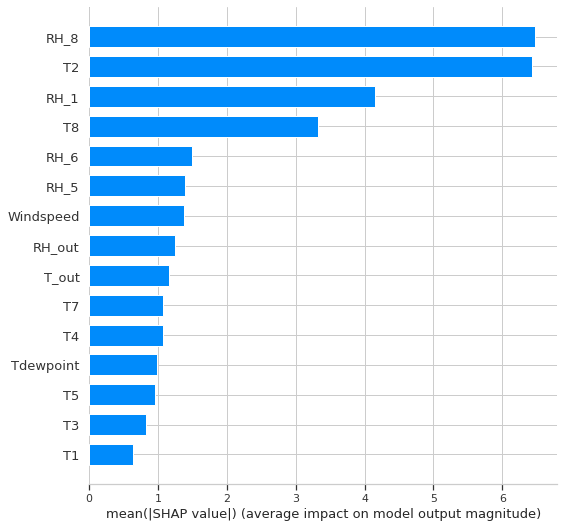

In [81]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


Observation: 

A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

Here, we can see the feature importance for respective classes in a descending order. 

Features like RH_8, T2, RH_1, T8, RH_6, RH_5, Windspeed,RH_OUT and T_out having higher importance over the rest.

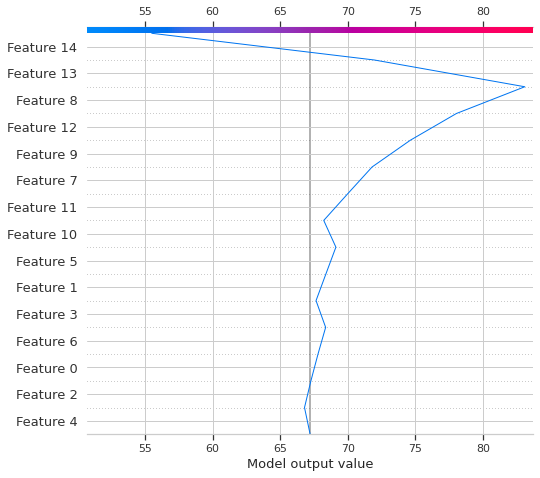

In [86]:
shap.decision_plot(explainer.expected_value[0], shap_values[0])

You will able to connect how contribution and values have been explaining here in the graph. 

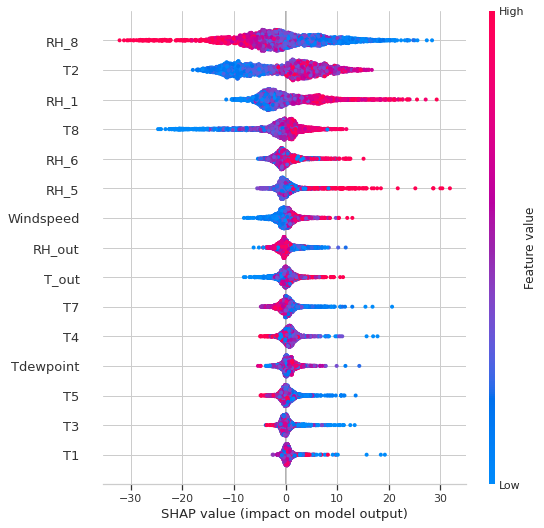

In [83]:
shap.summary_plot(shap_values, X_test)

Observation:

This plot is made of all the dots in the train data. It demonstrates the following information:

**Feature importance:** Variables are ranked in descending order.

**Original value:** Color shows whether that variable is high (in red) or low (in blue) for that observation.

**Correlation:** A high level of the "RH_8" content has a low and Positive impact on the "Appliances". The "low" comes from the blue color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “RH_1” and "RH_5" is positively correlated with the target variable.

Red indicates a higher  and blue indicates a lower . From the X-axis we can verify the impact (Positive or Negative) for that specific data.

In [85]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(regressor_dtc)
# obtain shap values for the first row of the test data
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

Explainability Conclusion

**The base value:** The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction(Appliances), or mean(yhat).

**Red/blue:** Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue such as T2 and T8.

**T_out, T7, T5, T1 AND T3:** has a negative impact on the target variable. These column content is different for each  which are lower than the average value of these particular column. So it pushes the prediction to the right.

**T8 and T2 :** has a positive impact on the target variable. A higher than the average T8 and T2 respectively drives the prediction to the left.

The average value that is the base value of an outcome is typically right here is  67.22 and features in "red" are contributing to driving all these values above the base value. Features in "blue" are driving all the values below the base value. The direction is showing you the importance of every feature to driving it above or below the base value. 

# Conclusion

We have reached the end of our notebook.

Starting with loading the data so far we have done EDA , null values treatment, dropping unnecessory columns, outliers handling, visualization, knowing the distribution, feature engineering, model making and then finalizing our best model with the help of hyperparameter tuning. At the end we also did shap for our model explaination.


The Random Forest Regressor was the best model when compared with rest all models for this data set. For all the models This regressor worked the best because it prevents the data from overfitting and plus it predicted very well based on all the features which is important. Few features were not useful for some models but to create a common platform they were tested for all features.

It gives 0.86 r2 on train and around 0.70 r2 on test data which can be good enough

# Improvemente points:

Definitely, we have a scope of improvement here, specially in the feature engineering. Many of the features are skewed. We can do some more EDA and FE to extract better features which can have better relationships with the target variable. Below are some more transformation which we can do to data.

To handle skeweness data:
1. We can apply some transformation like log, exp, boxcox, reciprocal on skewed features.
2. We can do discretisation on on some highly skewed data and check how it is performing.
3. Treat outliers as missing data and do imputation on them
4. Model interpretation:
5. We can also use shap value to interprete the predictions.

# Future Work

We can do a dynamic regression time series modelling due to the availability of the time features.
We can use topic modelling to tackle views in each topic separately.

# That's all..!!